# Part 3 - Employ notebooks to synthesize query project results

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%reload_ext google.cloud.bigquery

## Loading Data to Pandas DataFrames

### Dataframe of all trips broken down by start hour, day of the week, and weekday/weekend

In [2]:
%%bigquery --use_rest_api trip_hours_dowstr_df

SELECT dow_str, dow_weekday, start_hour, #count(*) as num_trips,
    FROM
    (
    SELECT start_date,
           EXTRACT(DAYOFWEEK FROM start_date) AS dow_int,
           CASE EXTRACT(DAYOFWEEK FROM start_date)
               WHEN 1 THEN "Sunday"
               WHEN 2 THEN "Monday"
               WHEN 3 THEN "Tuesday"
               WHEN 4 THEN "Wednesday"
               WHEN 5 THEN "Thursday"
               WHEN 6 THEN "Friday"
               WHEN 7 THEN "Saturday"
               END AS dow_str,
           CASE 
               WHEN EXTRACT(DAYOFWEEK FROM start_date) IN (1, 7) THEN "Weekend"
               ELSE "Weekday"
               END AS dow_weekday,
           EXTRACT(HOUR FROM start_date) AS start_hour,
           CASE 
               WHEN EXTRACT(HOUR FROM start_date) <= 5  OR EXTRACT(HOUR FROM start_date) >= 23 THEN "Nightime"
               WHEN EXTRACT(HOUR FROM start_date) >= 6 and EXTRACT(HOUR FROM start_date) <= 8 THEN "Morning"
               WHEN EXTRACT(HOUR FROM start_date) >= 9 and EXTRACT(HOUR FROM start_date) <= 10 THEN "Mid Morning"
               WHEN EXTRACT(HOUR FROM start_date) >= 11 and EXTRACT(HOUR FROM start_date) <= 13 THEN "Mid Day"
               WHEN EXTRACT(HOUR FROM start_date) >= 14 and EXTRACT(HOUR FROM start_date) <= 16 THEN "Early Afternoon"
               WHEN EXTRACT(HOUR FROM start_date) >= 17 and EXTRACT(HOUR FROM start_date) <= 19 THEN "Afternoon"
               WHEN EXTRACT(HOUR FROM start_date) >= 20 and EXTRACT(HOUR FROM start_date) <= 22 THEN "Evening"
               END AS start_hour_str
    FROM `bigquery-public-data.san_francisco.bikeshare_trips`
    )
#     GROUP BY dow_str, start_hour, dow_weekday
#     ORDER BY num_trips DESC

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:407: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


In [3]:
trip_hours_dowstr_df

,dow_str,dow_weekday,start_hour
0,Friday,Weekday,10
1,Friday,Weekday,10
2,Friday,Weekday,13
3,Friday,Weekday,17
4,Friday,Weekday,17
...,...,...,...
983643,Wednesday,Weekday,15
983644,Wednesday,Weekday,9
983645,Wednesday,Weekday,14
983646,Wednesday,Weekday,13


### Dataframe of number of trips grouped per day of the week grouped per hour

In [4]:
trip_hours_dowstr_count = trip_hours_dowstr_df.groupby(["start_hour", "dow_str"]).count().rename(
                          columns={'dow_weekday': 'num_trips'})
trip_hours_dowstr_count

num_trips
start_hour dow_str             
0          Friday           427
           Monday           228
           Saturday         645
           Sunday           588
           Thursday         380
...                         ...
23         Saturday         928
           Sunday           470
           Thursday        1074
           Tuesday          860
           Wednesday        969

[168 rows x 1 columns]

### Dataframe of all the trips that fall during a commuter time

In [5]:
%%bigquery --use_rest_api commuter_station_df

SELECT start_station_name, end_station_name, start_hour,
    FROM 
    (
      SELECT start_station_name, end_station_name, start_date,
        EXTRACT(DAYOFWEEK FROM start_date) AS dow_int,
               CASE 
                   WHEN EXTRACT(DAYOFWEEK FROM start_date) IN (1, 7) THEN "Weekend"
                   ELSE "Weekday"
                   END AS dow_weekday,     
        EXTRACT(HOUR FROM start_date) AS start_hour,
              CASE 
                WHEN EXTRACT(HOUR FROM start_date) >= 7 and EXTRACT(HOUR FROM start_date) <= 9 THEN "Commuter"
                WHEN EXTRACT(HOUR FROM start_date) >= 16 and EXTRACT(HOUR FROM start_date) <= 18 THEN "Commuter"
                END AS start_hour_str,
          FROM `bigquery-public-data.san_francisco.bikeshare_trips`
    )
    WHERE dow_weekday = "Weekday" AND start_hour_str = "Commuter"

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:407: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


In [6]:
commuter_station_df

,start_station_name,end_station_name,start_hour
0,Japantown,Japantown,7
1,Japantown,Japantown,7
2,Japantown,Japantown,7
3,Japantown,Japantown,7
4,Japantown,Japantown,7
...,...,...,...
560678,Yerba Buena Center of the Arts (3rd @ Howard),Yerba Buena Center of the Arts (3rd @ Howard),18
560679,Yerba Buena Center of the Arts (3rd @ Howard),Yerba Buena Center of the Arts (3rd @ Howard),18
560680,Yerba Buena Center of the Arts (3rd @ Howard),Yerba Buena Center of the Arts (3rd @ Howard),18
560681,Yerba Buena Center of the Arts (3rd @ Howard),Yerba Buena Center of the Arts (3rd @ Howard),18


### Dataframe counting the number of trips grouped by hour grouped by start station

In [7]:
commuter_station_count = commuter_station_df.groupby(['start_station_name', 'start_hour']).count().rename(
                                                    columns={'start_station_name': 'station_name',
                                                             'end_station_name': 'num_trips'})
commuter_station_count

num_trips
start_station_name                            start_hour           
2nd at Folsom                                 7                 681
                                              8                2159
                                              9                1654
                                              16               2436
                                              17               4058
...                                                             ...
Yerba Buena Center of the Arts (3rd @ Howard) 8                 704
                                              9                 747
                                              16               1228
                                              17               2603
                                              18               1499

[487 rows x 1 columns]

### Dataframe of duration of all trips

In [8]:
%%bigquery --use_rest_api duration_df

SELECT duration_sec, 
CAST(ROUND(duration_sec / 60.0) AS INT64) AS duration_minutes,
CAST(ROUND(duration_sec / 3600.0) AS INT64) AS duration_hours_rounded,
CAST(ROUND(duration_sec / 86400.0) AS INT64) AS duration_days_rounded
FROM `bigquery-public-data.san_francisco.bikeshare_trips`


/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:407: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


In [9]:
duration_df

,duration_sec,duration_minutes,duration_hours_rounded,duration_days_rounded
0,2618,44,1,0
1,5957,99,2,0
2,5913,99,2,0
3,6079,101,2,0
4,5780,96,2,0
...,...,...,...,...
983643,1303,22,0,0
983644,1337,22,0,0
983645,1310,22,0,0
983646,1325,22,0,0


### Dataframe of duration in minutes, put into bins

In [10]:
%%bigquery --use_rest_api duration_bins

SELECT duration_sec, 
    CAST(ROUND(duration_sec / 60.0) AS INT64) AS duration_minutes,
    CASE 
        WHEN CAST(ROUND(duration_sec / 60.0) AS INT64) <= 2 THEN "< 2 min"
        WHEN CAST(ROUND(duration_sec / 60.0) AS INT64) >= 2 and CAST(ROUND(duration_sec / 60.0) AS INT64) <= 60 THEN "< 1 hour"
        WHEN CAST(ROUND(duration_sec / 60.0) AS INT64) >= 60 and CAST(ROUND(duration_sec / 60.0) AS INT64) <= 300 THEN "< 5 hours"
        WHEN CAST(ROUND(duration_sec / 60.0) AS INT64) >= 300  and CAST(ROUND(duration_sec / 60.0) AS INT64) <= 1440 THEN "< 1 day"
        WHEN CAST(ROUND(duration_sec / 60.0) AS INT64) >= 1440 THEN "> 1 day"
        END AS duration_bins
FROM `bigquery-public-data.san_francisco.bikeshare_trips`

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:407: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


In [11]:
duration_bins

,duration_sec,duration_minutes,duration_bins
0,2618,44,< 1 hour
1,5957,99,< 5 hours
2,5913,99,< 5 hours
3,6079,101,< 5 hours
4,5780,96,< 5 hours
...,...,...,...
983643,1303,22,< 1 hour
983644,1337,22,< 1 hour
983645,1310,22,< 1 hour
983646,1325,22,< 1 hour


### Dataframe of counts per duration bins

In [12]:
duration_bins_count = duration_bins.groupby('duration_bins').count().drop('duration_sec',axis=1).rename(columns={'duration_minutes':'num_trips'})
duration_bins_count

,num_trips
duration_bins,
< 1 day,4781
< 1 hour,938658
< 2 min,17077
< 5 hours,22836
> 1 day,296


## Data Visualization

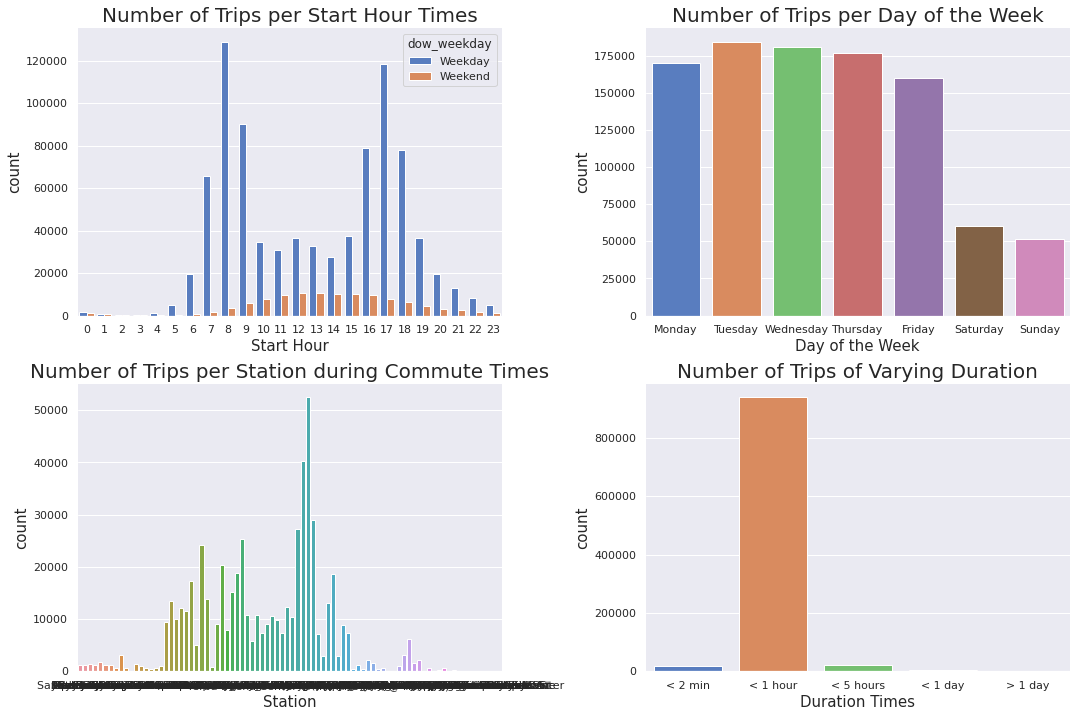

In [13]:
sns.set(style="darkgrid", palette="muted", color_codes=True, 
        rc={"font.size":8,"axes.titlesize":20,"axes.labelsize":15})

# Set up the matplotlib figure
f, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.despine(left=True)

sns.countplot(x="start_hour", hue= "dow_weekday", 
              data=trip_hours_dowstr_df, ax = axes[0,0]).set(title='Number of Trips per Start Hour Times',
                                                           xlabel='Start Hour')

sns.countplot(x="dow_str", order=['Monday','Tuesday','Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
              data=trip_hours_dowstr_df, ax = axes[0,1]).set(title='Number of Trips per Day of the Week',
                                                           xlabel='Day of the Week')

sns.countplot(x="start_station_name", 
              data=commuter_station_df, ax = axes[1,0]).set(title='Number of Trips per Station during Commute Times', 
                                                                              xlabel='Station')

sns.countplot(x="duration_bins", order=['< 2 min', '< 1 hour', '< 5 hours', '< 1 day', '> 1 day'],
              data=duration_bins, ax = axes[1,1]).set(title='Number of Trips of Varying Duration', 
                                                                              xlabel='Duration Times')

plt.tight_layout()

## Data Analysis

### Commute Time Definition

Number of Trips per Start Hour Times is divided between weekends and weekdays. You can see that the peaks that exist only in the weekday division suggest commute times. From this graph, I decided to define 'commute time' to be 7-9am and 4-6pm. Specifically, I looked only at the start_time columns to define 'commute time', because that suggests the time someone decides to leave for or from work.

### 5 Most Popular "Commuter Trips"

I am defining popular to mean the most trips coming from that station. In this case, I'm only looking at start stations because I am only looking at start times for commute time. The following dataframe shows the 5 most popular stations and their respective number of commuter trips (trips that start within 7-9am or 4-6pm).

In [14]:
commuter_station = commuter_station_df.drop('start_hour',axis=1).rename(columns=
                {'end_station_name':'num_trips'}).groupby('start_station_name').count().sort_values(by=['num_trips'], ascending=False)
commuter_station.head()

,num_trips
start_station_name,
San Francisco Caltrain (Townsend at 4th),52441
San Francisco Caltrain 2 (330 Townsend),40264
Temporary Transbay Terminal (Howard at Beale),28880
Harry Bridges Plaza (Ferry Building),27298
Steuart at Market,25313


### Trend Analysis and Recommendations for Offers

Commuter Membership: Looking at the graphs Number of Trips per Start Hour Times and Number of Trips per Day of the Week, we can see that the main customers for Lyft Bay Wheels are commuters. It might be beneficial to provide a membership that charges monthly or annually at a cheaper rate than single rides. Like Bike Share for All, this membership might include the first 60 minutes of a trip and then charge 2 dollars for each additional minute. This membership would probably cost slightly more than Bike Share for All (for example a 10 dollar first-year Annual Membership instead of 5 dollar) because Bike Share for All has specific eligibility. 

Weekend Offers: Looking at the graphs Number of Trips per Start Hour Times and Number of Trips per Day of the Week, we see that weekend trips are much less frequent than weekday trips by nearly half the amount. It might be beneficial to offer discounts to incentivise taking trips on the weekends. 

Early Bird Offers: Looking at the Number of Trips per Start Hour Times, we can see that the number of trips before 7am drastically decrease. However, for some, commute times might extend that early. In order to stay loyal to our commuter customer pool, the company might consider an early bird discount between the hours of 4-6am during the weekdays to suggest that we care about our commuter customers and we care about early commuters. 

Multi-Day Deals: Looking at the graph Number of Trips of Varying Duration, we see that most of our trip durations fall under 1 hour. Those that fall under < 2 minutes suggest that either a bike wasn't working, a customer had changed their mind, or it was in fact a really short ride. There are not many rides that go beyond an hour. There are only 296 trips that are longer than 1 day. While that is a short fraction of the total number of trips, making a multi-day trip deal might incentivize longer trips. Similarly to how AirBnb provides a discount for customers who reserve a location for at least a month, we might consider a  15% discount if customers choose to take trips that are maybe a week or longer. 